# Imports

In [1]:
# Import data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az
import pytensor.tensor as pt
from datetime import datetime

from scipy import stats
from itertools import combinations

# Team Colors

## Functions

In [2]:
def hex_to_rgb(hex):
    hex = hex.lstrip('#')
    hlen = len(hex)
    return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def get_color_distance(color1, color2):
    return np.sqrt(np.sum((np.array(color1) - np.array(color2))**2))

def get_balanced_colors(home_main, home_alt, away_main, away_alt):
    
    color_pairs = [
        (home_main, away_main),
        (home_main, away_alt),
        (home_alt, away_main),
        (home_alt, away_alt)
    ]
    
    distances = [get_color_distance(*pair) for pair in color_pairs]

    rgbs = color_pairs[np.argmax(distances)]
    
    return [rgb_to_hex(rgb) for rgb in rgbs]

## Load Team Color Data

In [3]:
team_colors = pd.read_csv('../data/teams/team_colors.csv')

team_colors.fillna('#000000', inplace=True)

team_colors['main_rgb'] = team_colors['color'].apply(hex_to_rgb)
team_colors['alt_rgb'] = team_colors['alt_color'].apply(hex_to_rgb)

team_colors.head()

,school,color,alt_color,main_rgb,alt_rgb
0,Air Force,#004a7b,#ffffff,"(0, 74, 123)","(255, 255, 255)"
1,Akron,#00285e,#84754e,"(0, 40, 94)","(132, 117, 78)"
2,Alabama,#690014,#f1f2f3,"(105, 0, 20)","(241, 242, 243)"
3,Appalachian State,#000000,#ffcd00,"(0, 0, 0)","(255, 205, 0)"
4,Arizona,#002449,#00205b,"(0, 36, 73)","(0, 32, 91)"


# Game Data

In [16]:
df22 = pd.read_csv('../data/games/2022_scores.csv')
df23 = pd.read_csv('../data/games/2023_scores.csv')

max_week_2022 = df22['week'].max()
df23['week'] = df23['week'] + max_week_2022

df = pd.concat((df22, df23))

last_week = df['week'].max()
df = df[df['week'] >= last_week - 9]

df.rename(columns={'home': 'home_team', 'away': 'away_team'}, inplace=True)

In [18]:
ht = df['home_team'].unique()
at = df['away_team'].unique()

h_not_a = [x for x in ht if x not in at]
a_not_h = [x for x in at if x not in ht]

others = list(set(h_not_a + a_not_h)) + ['Lindenwood']

df['home_team'] = df['home_team'].replace(others, 'Other')
df['away_team'] = df['away_team'].replace(others, 'Other')

In [19]:
df.head()

,game_id,week,year,home_team,away_team,home_tds,home_fgs,away_tds,away_fgs
90,401403946,12,2022,Alabama,Austin Peay,4,2,0,0
91,401403947,12,2022,Arkansas,Ole Miss,6,0,3,2
92,401403949,12,2022,Kentucky,Georgia,1,0,1,3
93,401403951,12,2022,Mississippi State,Other,7,0,0,0
94,401403952,12,2022,Missouri,New Mexico State,5,1,2,0


# Model

## Coordinates

In [20]:
home_idx, teams = pd.factorize(df['home_team'], sort=True)
away_idx, _ = pd.factorize(df['away_team'], sort=True)
coords = {"team": teams}

## Global Parameters

In [21]:
with pm.Model(coords=coords) as model:
    
    home_team = pm.MutableData("home_team", home_idx, dims="game")
    away_team = pm.MutableData("away_team", away_idx, dims="game")

    # global model parameters
    td_intercept = pm.Normal("td_intercept", mu=0, sigma=5)
    fg_intercept = pm.Normal("fg_intercept", mu=0, sigma=5)

## Touchdowns

In [22]:
with model:
    
    # team-specific model parameters
    offense_td_star = pm.Normal("offense_td_star", mu=0, sigma=5, dims="team")
    defense_td_star = pm.Normal("defense_td_star", mu=0, sigma=5, dims="team")
    home_field_td_advantage_star = pm.Normal("home_field_td_advantage_star", mu=0, sigma=5, dims="team")
    
    offense_td = pm.Deterministic("offense_td", offense_td_star - pt.mean(offense_td_star), dims="team")
    defense_td = pm.Deterministic("defense_td", defense_td_star - pt.mean(defense_td_star), dims="team")
    home_field_td_advantage = pm.Deterministic("home_field_td_advantage", home_field_td_advantage_star - pt.mean(home_field_td_advantage_star), dims="team")

    home_td_theta = pt.exp(td_intercept + home_field_td_advantage[home_idx] + offense_td[home_idx] - defense_td[away_idx])
    away_td_theta = pt.exp(td_intercept + offense_td[away_idx] - defense_td[home_idx])
    
    # likelihood of observed data
    home_tds = pm.Poisson(
        "home_tds",
        mu=home_td_theta,
        observed=df["home_tds"],
        dims=("game"),
    )
    away_tds = pm.Poisson(
        "away_tds",
        mu=away_td_theta,
        observed=df['away_tds'],
        dims=("game"),
    )

## Field Goals

In [23]:
with model:
    
    # team-specific model parameters
    offense_fg_star = pm.Normal("offense_fg_star", mu=0, sigma=5, dims="team")
    defense_fg_star = pm.Normal("defense_fg_star", mu=0, sigma=5, dims="team")
    home_field_fg_advantage_star = pm.Normal("home_field_fg_advantage_star", mu=0, sigma=5, dims="team")
    
    offense_fg = pm.Deterministic("offense_fg", offense_fg_star - pt.mean(offense_fg_star), dims="team")
    defense_fg = pm.Deterministic("defense_fg", defense_fg_star - pt.mean(defense_fg_star), dims="team")
    home_field_advantage = pm.Deterministic("home_field_fg_advantage", home_field_fg_advantage_star - pt.mean(home_field_fg_advantage_star), dims="team")

    home_fg_theta = pt.exp(fg_intercept + home_field_advantage[home_idx] + offense_fg[home_idx] - defense_fg[away_idx])
    away_fg_theta = pt.exp(fg_intercept + offense_fg[away_idx] - defense_fg[home_idx])
    
    # likelihood of observed data
    home_fgs = pm.Poisson(
        "home_fgs",
        mu=home_fg_theta,
        observed=df["home_fgs"],
        dims=("game"),
    )
    away_fgs = pm.Poisson(
        "away_fgs",
        mu=away_fg_theta,
        observed=df['away_fgs'],
        dims=("game"),
    )

## Sample

In [24]:
with model:
    
    total = pm.Deterministic('total', offense_td + defense_td, dims='team')
    
    trace = pm.sample(5_000, tune=5_000, cores=5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [td_intercept, fg_intercept, offense_td_star, defense_td_star, home_field_td_advantage_star, offense_fg_star, defense_fg_star, home_field_fg_advantage_star]


Sampling 5 chains for 5_000 tune and 5_000 draw iterations (25_000 + 25_000 draws total) took 290 seconds.


## Plot Trace

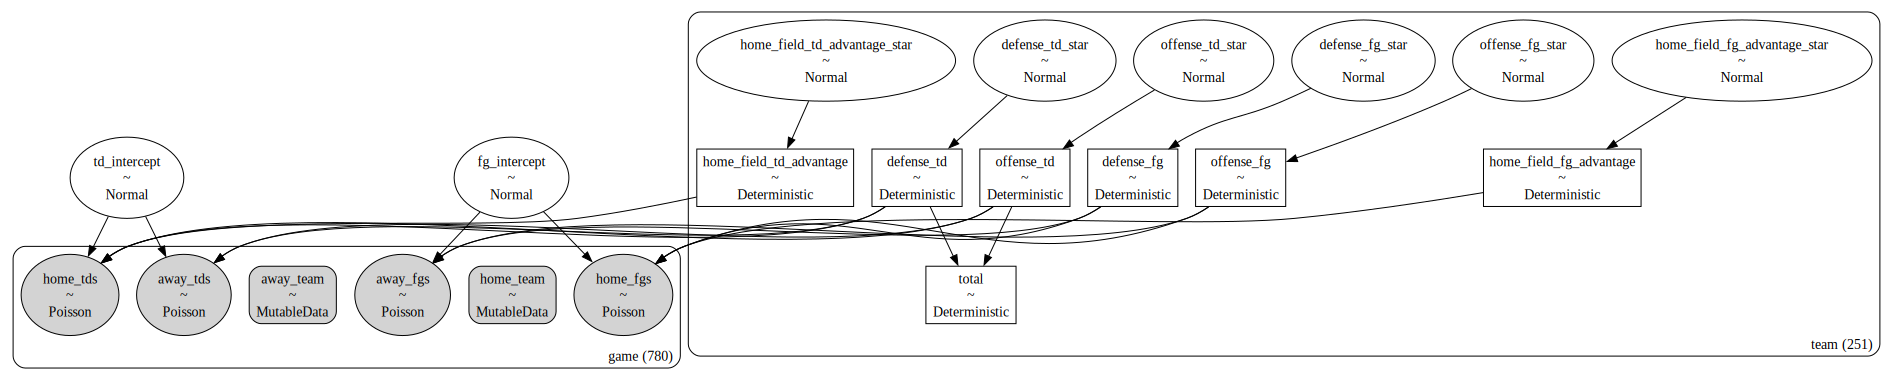

In [25]:
pm.model_to_graphviz(model)

array([[<Axes: title={'center': 'td_intercept'}>,
        <Axes: title={'center': 'td_intercept'}>],
       [<Axes: title={'center': 'fg_intercept'}>,
        <Axes: title={'center': 'fg_intercept'}>]], dtype=object)

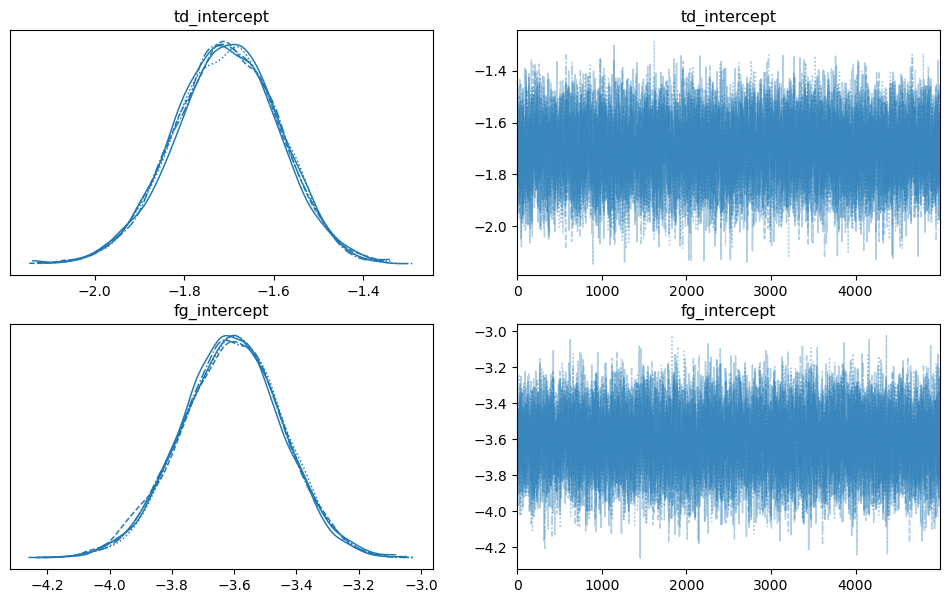

In [26]:
az.plot_trace(trace, var_names=['td_intercept', 'fg_intercept'], figsize=(12, 7))

In [27]:
top_25 = ['Georgia', 'Michigan', 'Texas', 'Ohio State', 'Florida State', 'Penn State', 'Washington', 'USC', 'Oregon', 'Utah', 'Notre Dame', 'Alabama', 'LSU', 'Oklahoma', 'North Carolina', 'Washington State', 'Duke', 'Miami', 'Oregon State', 'Ole Miss', 'Tennessee', 'Florida', 'Missouri', 'Kansas', 'Fresno State', 'Clemson']

len(top_25)

26

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

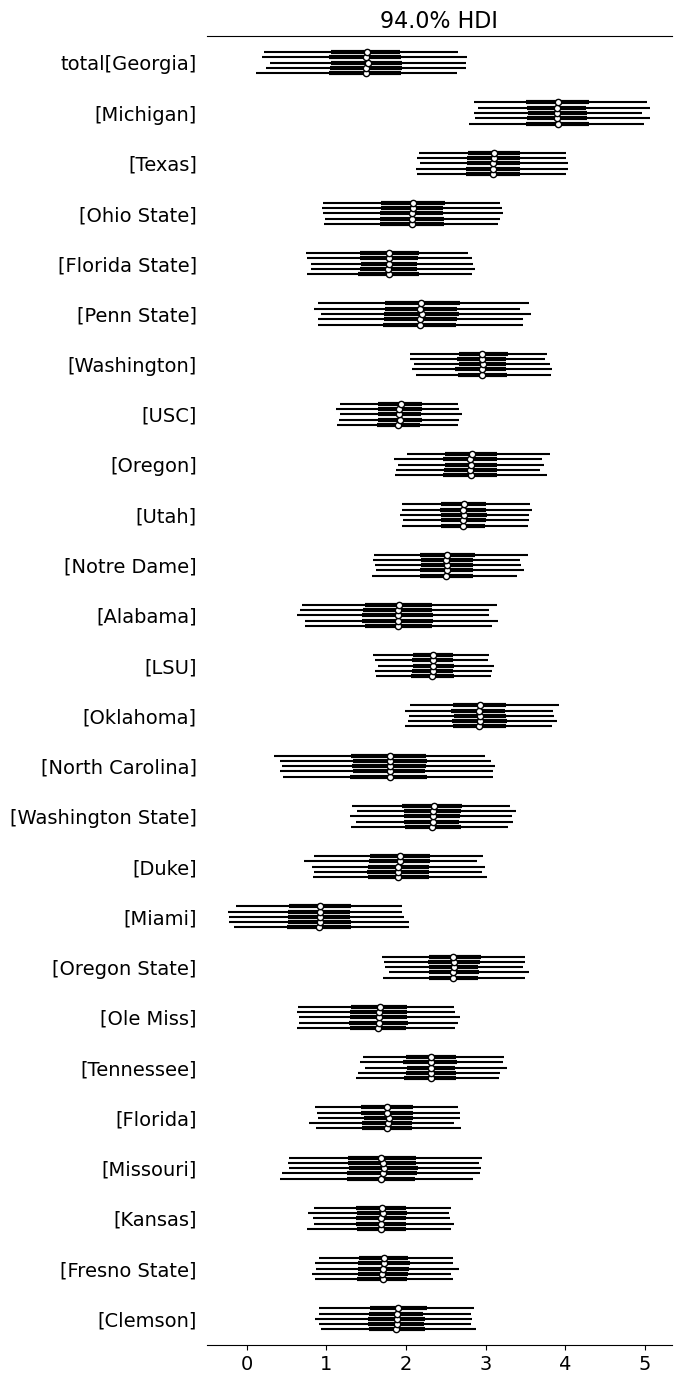

In [28]:
az.plot_forest(trace, var_names=['total'], coords={'team': top_25}, combined=False, kind='forestplot', colors='black')

## Plot Energy

<Axes: >

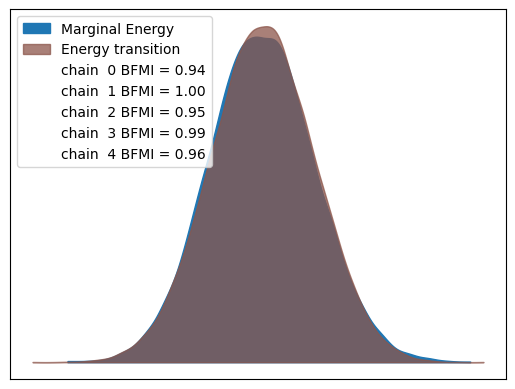

In [29]:
az.plot_energy(trace)

# Predict Functions

In [30]:
def get_touchdowns(home_team, away_team, trace):
    
    home_index = np.where(teams == home_team)[0]
    away_index = np.where(teams == away_team)[0]
    
    td_intercept = trace['posterior']['td_intercept'].values.flatten()
    home_field_td_advantage = trace['posterior']['home_field_td_advantage'][:, :, home_index].values.flatten()

    home_offense_td = trace['posterior']['offense_td'][:, :, home_index].values.flatten()
    home_defense_td = trace['posterior']['defense_td'][:, :, home_index].values.flatten()

    away_offense_td = trace['posterior']['offense_td'][:, :, away_index].values.flatten()
    away_defense_td = trace['posterior']['defense_td'][:, :, away_index].values.flatten()

    home_td_theta = np.exp(td_intercept + home_field_td_advantage + home_offense_td - away_defense_td)
    away_td_theta = np.exp(td_intercept + away_offense_td - home_defense_td)
    
    home_tds = stats.poisson.rvs(mu=home_td_theta)
    away_tds = stats.poisson.rvs(mu=away_td_theta)
    
    return home_tds, away_tds

In [31]:
def get_field_goals(home_team, away_team, trace):
    
    home_index = np.where(teams == home_team)[0]
    away_index = np.where(teams == away_team)[0]
    
    fg_intercept = trace['posterior']['fg_intercept'].values.flatten()
    home_field_fg_advantage = trace['posterior']['home_field_fg_advantage'][:, :, np.where(teams == home_team)[0]].values.flatten()

    home_offense_fg = trace['posterior']['offense_fg'][:, :, home_index].values.flatten()
    home_defense_fg = trace['posterior']['defense_fg'][:, :, home_index].values.flatten()

    away_offense_fg = trace['posterior']['offense_fg'][:, :, away_index].values.flatten()
    away_defense_fg = trace['posterior']['defense_fg'][:, :, away_index].values.flatten()

    home_fg_theta = np.exp(fg_intercept + home_field_fg_advantage + home_offense_fg - away_defense_fg)
    away_fg_theta = np.exp(fg_intercept + away_offense_fg - home_defense_fg)
    
    home_fgs = stats.poisson.rvs(mu=home_fg_theta)
    away_fgs = stats.poisson.rvs(mu=away_fg_theta)
    
    return home_fgs, away_fgs

In [32]:
def plot_touchdowns(home_team, away_team, trace, home_color='blue', away_color='red'):
    
    home_tds, away_tds = get_touchdowns(home_team, away_team, trace)
    
    fig, ax = plt.subplots()
    sns.histplot(home_tds, color=home_color, stat='density', ax=ax)
    sns.histplot(away_tds, color=away_color, stat='density', ax=ax)
    ax.set_title(f'Number of Touchdowns\n{home_team} vs {away_team}')
    plt.show()

In [33]:
def plot_field_goals(home_team, away_team, trace, home_color='blue', away_color='red'):
    
    home_fgs, away_fgs = get_field_goals(home_team, away_team, trace)
    
    fig, ax = plt.subplots()
    sns.histplot(home_fgs, color=home_color, stat='density', ax=ax)
    sns.histplot(away_fgs, color=away_color, stat='density', ax=ax)
    ax.set_title(f'Number of Field Goals\n{home_team} vs {away_team}')
    plt.show()

In [34]:
def get_points(home_team, away_team, trace):
    
    home_tds, away_tds = get_touchdowns(home_team, away_team, trace)
    home_fgs, away_fgs = get_field_goals(home_team, away_team, trace)
    
    home_points = 7 * home_tds + 3 * home_fgs
    away_points = 7 * away_tds + 3 * away_fgs
    
    return home_points, away_points

In [35]:
def get_predicted_score(home_team, away_team, trace):
    
    home_tds, away_tds = get_touchdowns(home_team, away_team, trace)
    home_fgs, away_fgs = get_field_goals(home_team, away_team, trace)
    
    home_points = 7 * stats.mode(home_tds).mode + 3 * stats.mode(home_fgs).mode
    away_points = 7 * stats.mode(away_tds).mode + 3 * stats.mode(away_fgs).mode
    
    return home_points, away_points

In [36]:
def plot_points(home_team, away_team, trace, home_color='blue', away_color='red', ax=None):
    
    home_points, away_points = get_points(home_team, away_team, trace)
    
    predicted_home_points, predicted_away_points = get_predicted_score(home_team, away_team, trace)
    probability_of_home_win = np.mean(home_points > away_points)
    predicted_winner = home_team if probability_of_home_win > 0.5 else away_team
    probability_of_winner = np.max((probability_of_home_win, 1 - probability_of_home_win))
    
    if ax is None:
        fig, ax = plt.subplots()
        
    sns.kdeplot(home_points, color=home_color, label=home_team, ax=ax)
    sns.kdeplot(away_points, color=away_color, label=away_team, ax=ax)
    
    ax.legend()
    ax.grid(visible=True, color='gray', linestyle='-', alpha=0.1, which='both')
    ax.set_title(f'Predicted Score\n{predicted_home_points} - {predicted_away_points}\nProbability of {predicted_winner} winning: {100*probability_of_winner:.2f}%')
    ax.set_xlabel('Points')

In [37]:
def get_spread(home_team, away_team, trace):
    
    home_points, away_points = get_points(home_team, away_team, trace)
    
    spread = home_points - away_points
    
    return spread

In [38]:
def plot_spread(home_team, away_team, trace, betting_line=None, ax=None):
    
    spread = get_spread(home_team, away_team, trace)
    
    statistical_spread = np.mean(spread)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    sns.kdeplot(spread, color='black', ax=ax)
    ax.axvline(statistical_spread, color='gray', linestyle='--', label='Statistical Spread')
    
    title = f'Spread\nStatistical Spread: {statistical_spread:.2f}'
    
    if betting_line:
        
        probability_of_over = np.mean(spread > betting_line)
        title += f'\nProbability of over:  {100*probability_of_over:.2f}%'
        
        ax.axvline(betting_line, color='red', linestyle='--', label='Betting Line')
    
    
    ax.legend()
    ax.grid(visible=True, color='gray', linestyle='-', alpha=0.1, which='both')
    ax.set_title(title)
    ax.set_xlabel('Points')

In [39]:
def get_over_under(home_team, away_team, trace):
    
    home_points, away_points = get_points(home_team, away_team, trace)
    
    over_under = home_points + away_points
    
    return over_under

In [40]:
def plot_over_under(home_team, away_team, trace, betting_line=None, ax=None):
    
    over_under = get_over_under(home_team, away_team, trace)
    
    statistical_over_under = np.mean(over_under)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    sns.kdeplot(over_under, color='black', ax=ax)
    ax.axvline(statistical_over_under, color='gray', linestyle='--', label='Statistical O/U')
    
    title = f'Over/Under\nStatistical O/U: {statistical_over_under:.2f}'
    
    if betting_line:
        
        probability_of_over = np.mean(over_under > betting_line)
        title += f'\nProbability of over:  {100*probability_of_over:.2f}%'
        
        ax.axvline(betting_line, color='red', linestyle='--', label='Betting Line')
    
    ax.legend()
    ax.grid(visible=True, color='gray', linestyle='-', alpha=0.1, which='both')
    ax.set_title(title)
    ax.set_xlabel('Points')

In [41]:
def plot_game(home_team, away_team, trace, spread_betting_line=None, over_under_betting_line=None, home_color=None, away_color=None, save=False):
    
    if home_color is None or away_color is None:
        try:
            home_colors = team_colors[team_colors['school'] == home_team][['main_rgb', 'alt_rgb']].values[0]
            away_colors = team_colors[team_colors['school'] == away_team][['main_rgb', 'alt_rgb']].values[0]
        
            home_color, away_color = get_balanced_colors(*home_colors, *away_colors)    
        except IndexError:
            home_color = 'blue'
            away_color = 'red'
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
    plot_points(home_team, away_team, trace, home_color, away_color, ax=axs[0])
    plot_spread(home_team, away_team, trace, spread_betting_line, ax=axs[1])
    plot_over_under(home_team, away_team, trace, over_under_betting_line, ax=axs[2])
    
    fig.suptitle(f'{away_team} at {home_team}', fontsize=16)
    fig.tight_layout()
    
    if save:
        fig.savefig(f'../images/{away_team}_at_{home_team}.png')
    else:
        plt.show()

# Predictions

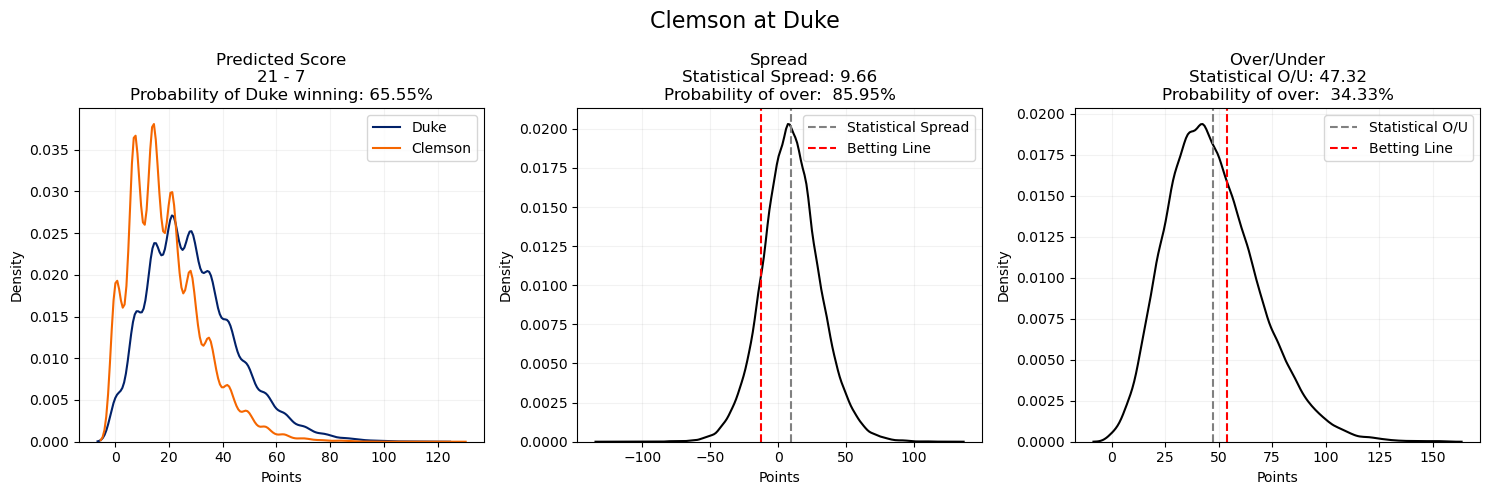

In [42]:
plot_game('Duke', 'Clemson', trace, spread_betting_line=-12.5, over_under_betting_line=54, save=True, home_color='#012169', away_color='#F56600')

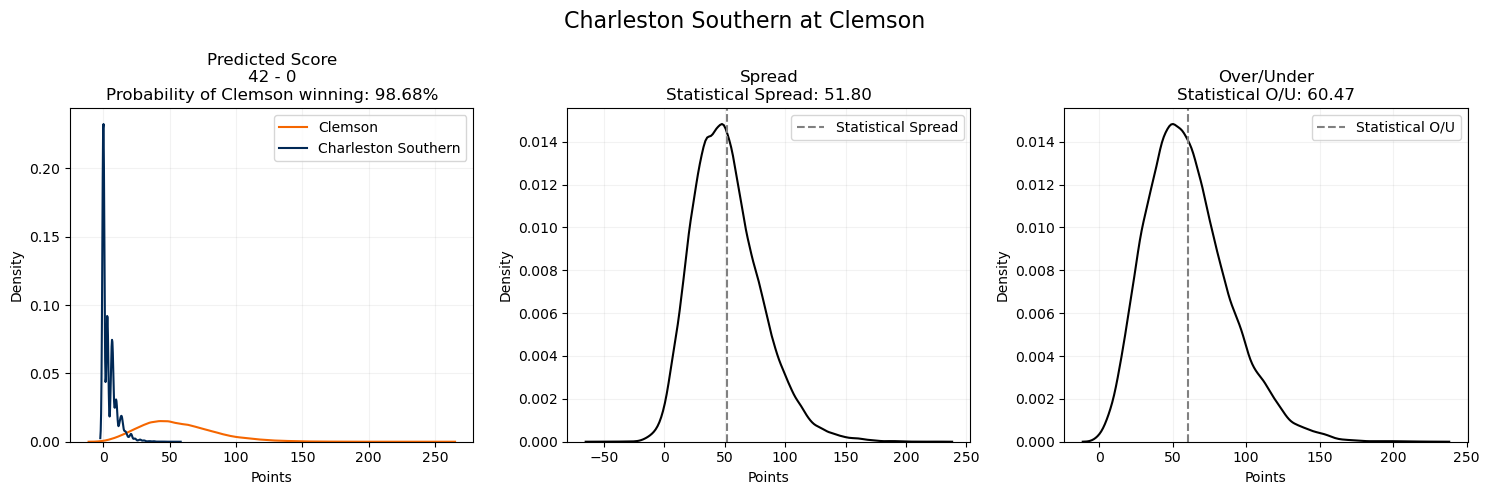

In [43]:
plot_game('Clemson', 'Charleston Southern', trace, home_color='#F56600', away_color='#002855', save=True)

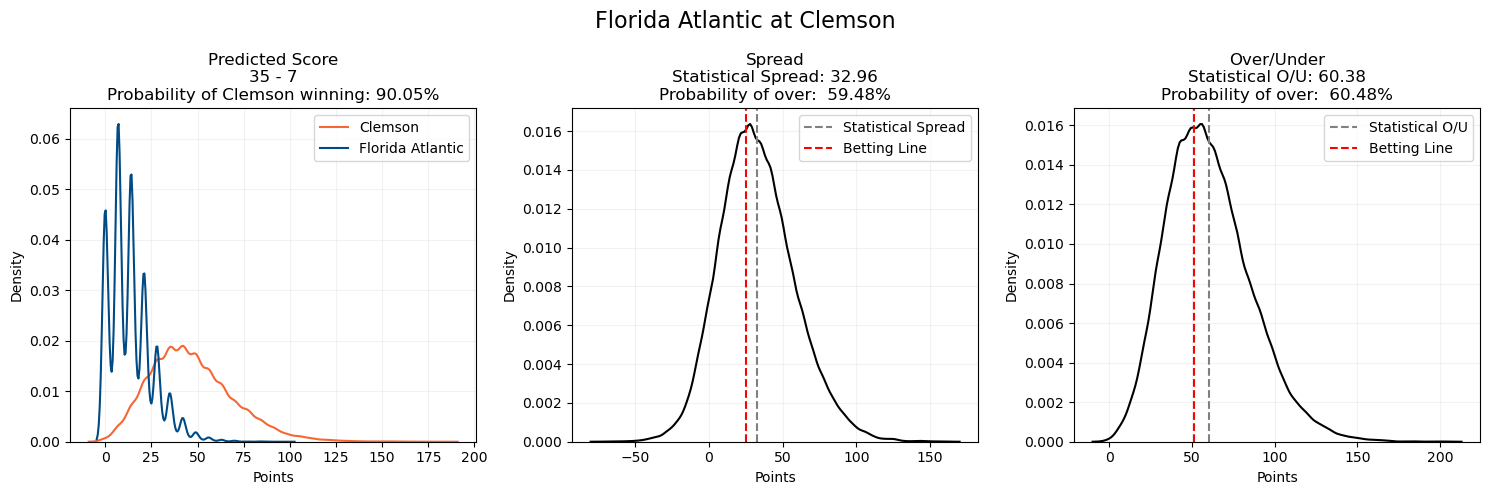

In [44]:
plot_game('Clemson', 'Florida Atlantic', trace, spread_betting_line=25, over_under_betting_line=51.5, save=True)

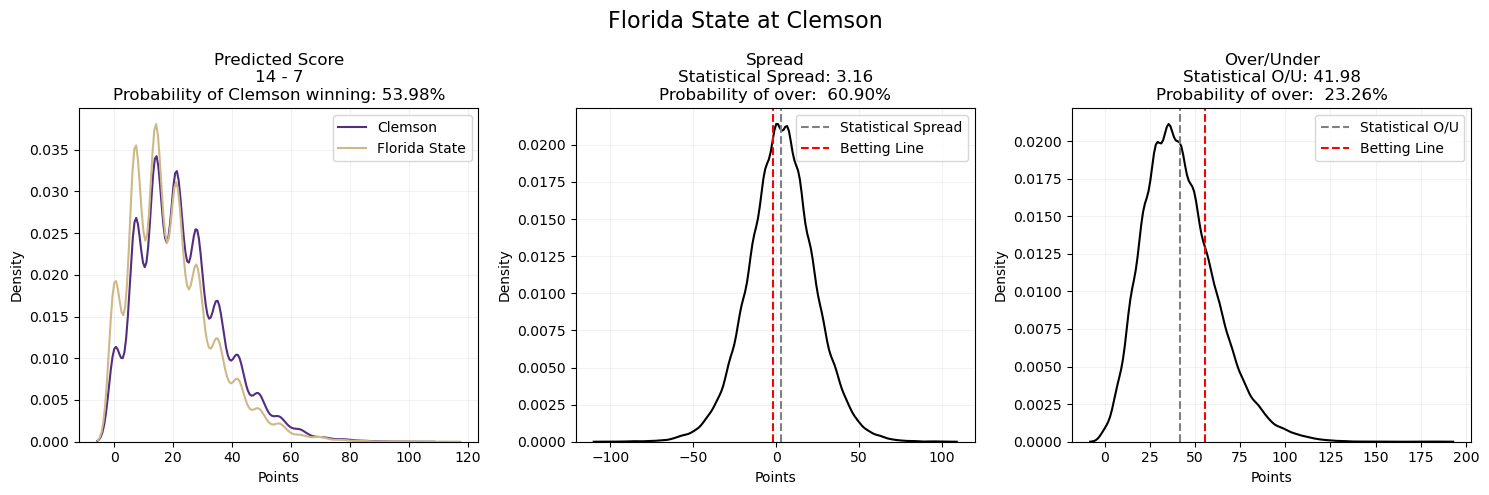

In [45]:
plot_game('Clemson', 'Florida State', trace, spread_betting_line=-2, over_under_betting_line=55.5, save=True)

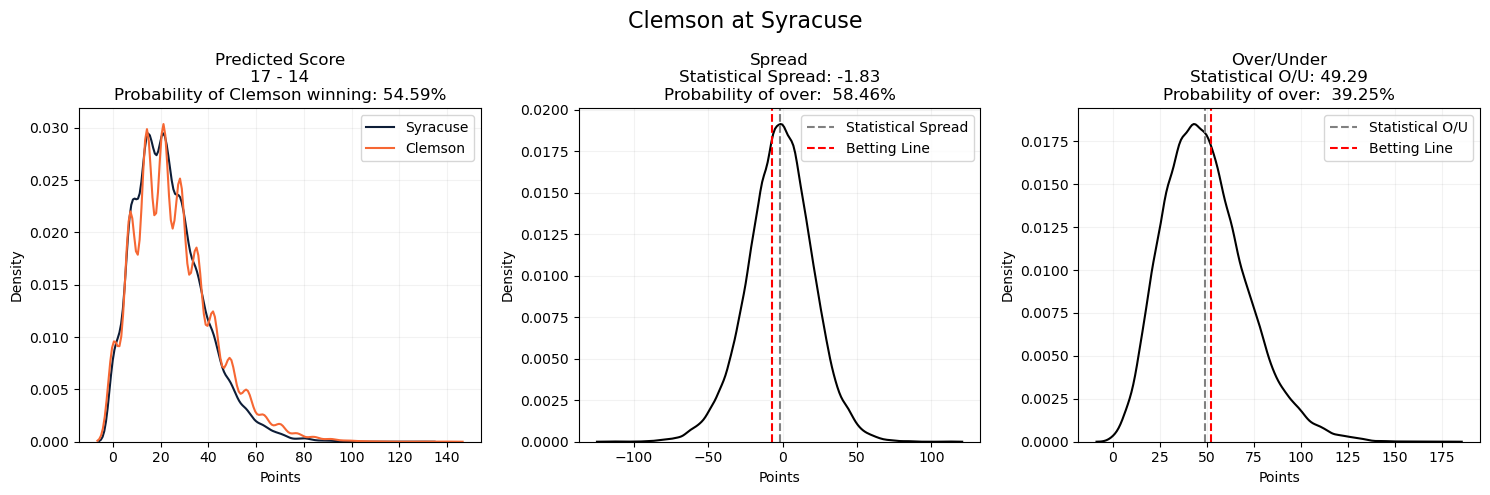

In [46]:
plot_game('Syracuse', 'Clemson', trace, spread_betting_line=-7, over_under_betting_line=52, save=True)

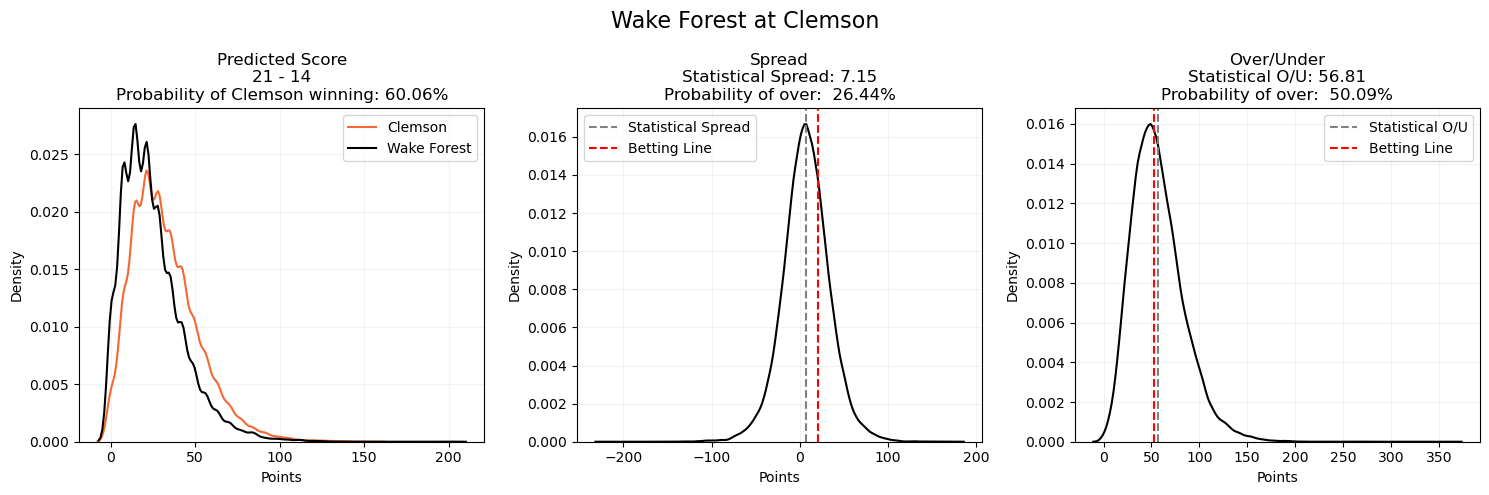

In [47]:
plot_game('Clemson', 'Wake Forest', trace, spread_betting_line=21, over_under_betting_line=52.5, save=True)

In [48]:
team_total_score = {
    'team': [],
    'total': []
}

for team in teams:

    team_index = np.where(teams == team)[0]
    
    team_totals = trace['posterior']['total'][:, :, team_index].values.flatten()

    team_mean_total = np.mean(team_totals)
    
    team_total_score['team'].append(team)
    team_total_score['total'].append(team_mean_total)

In [49]:
def simulate(first_team, second_team, trace):
    
    # Game 1:  first_team is home_team
    home_points, away_points = get_predicted_score(first_team, second_team, trace)
    first_game_winner = first_team if home_points > away_points else second_team

    # Game 2:  second_team is home_team
    home_points, away_points = get_predicted_score(second_team, first_team, trace)
    second_game_winner = second_team if home_points > away_points else first_team
    
    return first_game_winner, second_game_winner

In [50]:
simulation_results = {}

comb = combinations(top_25, 2)

for first_team, second_team in list(comb):
    
    first_game_winner, second_game_winner = simulate(first_team, second_team, trace)
    
    if first_game_winner in simulation_results:
        simulation_results[first_game_winner] += 1
    else:
        simulation_results[first_game_winner] = 1
        
    if second_game_winner in simulation_results:
        simulation_results[second_game_winner] += 1
    else:
        simulation_results[second_game_winner] = 1

In [51]:
top_25_plus_clemson = pd.DataFrame({
    'team': list(simulation_results.keys()),
    'wins': list(simulation_results.values())
}).sort_values('wins', ascending=False).reset_index(drop=True)

top_25_plus_clemson.to_csv('top_25_plus_clemson.csv')